# Analyze Swimming Trajectories

# Importations

In [1]:
import numpy as np
from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit 
from scipy.stats import ttest_ind
from scipy import stats
from scipy import signal
import seaborn as sns
from tqdm import tqdm
from scipy.signal import savgol_filter
import peakutils
import copy
import pandas as pd
import glob

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib as mpl
from matplotlib import rc
import matplotlib.colors as mplcolors
# from mpltools import annotation

rc('lines', linewidth=1.5, markeredgecolor='k', markeredgewidth=0.5)
rc('xtick', direction='in', labelsize=9)
rc('ytick', direction='in', labelsize=9)

rc('font', family='serif', size=9)
rc('text', usetex=True)

rc('figure', dpi=600)
rc('savefig', dpi=600)

# Auxiliary Functions

In [3]:
# Convert a string of a variable name to the variable itself
def str2var(string):
    return globals()[string]

In [4]:
# Open .mat for holography experiments
def open_xyz_mat(pathname, upward=False, version='new'):
    data = loadmat(pathname, squeeze_me=True)
    raw_data = np.zeros((len(data['x']), 3))
    raw_data[:,0] = data['x']
    raw_data[:,1] = data['y']
    raw_data[:,2] = data['z']
    del data
    return raw_data

In [5]:
def remove_end_zeros(data):
    try:
        ind = list(data[:,0]).index(0)
        data = data[:ind,:]
    except ValueError:
        data = data[:]
        # print('No pb. No zero in raw data.')
    return data

# Load Data

In [6]:
# dirs = [] 
# for folder in glob.glob('datas/*'):
#     for ffolder in glob.glob(folder + '/*'):
#         dirs.append(glob.glob(ffolder + '/traj*.mat')[0])
# dirs

dirs = [
    'datas_holography/20230517/10_trimmed_2/traj_rp_2p6119_np_1p4965_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_7_s_to_10_s.mat',
    'datas_holography/20230517/9_trimmed_2/traj_rp_2p5719_np_1p3906_VideoName_9_Basler_acA1920-155um__22392621__20230517_195639014_trimmed_from_3_s_to_4_s.mat',
    'datas_holography/20230517/11_trimmed_1/traj_rp_2p5214_np_1p3877_VideoName_11_Basler_acA1920-155um__22392621__20230517_200203077_trimmed_from_4_s_to_5_s.mat',
    'datas_holography/20230517/10_trimmed_1/traj_rp_2p1924_np_1p3934_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_4_s_to_6_s.mat',
    'datas_holography/20230517/10_trimmed_3/traj_rp_2p1387_np_1p4057_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_9_s_to_10_s.mat',
    'datas_holography/20230511_3rd_slide/4_trimmed_1/traj_rp_3p933_np_1p3933_VideoName_4_Basler_acA1920-155um__22392621__20230511_193611662_trimmed_from_0_s_to_3_s.mat',
    'datas_holography/20230511_3rd_slide/2_trimmed_1/test_2/traj_rp_3p2295_np_1p4139_VideoName_2_Basler_acA1920-155um__22392621__20230511_191132584_trimmed_from_28_s_to_41_s.mat',
    'datas_holography/20230511_3rd_slide/4_trimmed_3/traj_rp_3p6093_np_1p39_VideoName_4_Basler_acA1920-155um__22392621__20230511_193611662_trimmed_from_11_s_to_14_s.mat', 
]
dirs

['datas_holography/20230517/10_trimmed_2/traj_rp_2p6119_np_1p4965_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_7_s_to_10_s.mat',
 'datas_holography/20230517/9_trimmed_2/traj_rp_2p5719_np_1p3906_VideoName_9_Basler_acA1920-155um__22392621__20230517_195639014_trimmed_from_3_s_to_4_s.mat',
 'datas_holography/20230517/11_trimmed_1/traj_rp_2p5214_np_1p3877_VideoName_11_Basler_acA1920-155um__22392621__20230517_200203077_trimmed_from_4_s_to_5_s.mat',
 'datas_holography/20230517/10_trimmed_1/traj_rp_2p1924_np_1p3934_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_4_s_to_6_s.mat',
 'datas_holography/20230517/10_trimmed_3/traj_rp_2p1387_np_1p4057_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_9_s_to_10_s.mat',
 'datas_holography/20230511_3rd_slide/4_trimmed_1/traj_rp_3p933_np_1p3933_VideoName_4_Basler_acA1920-155um__22392621__20230511_193611662_trimmed_from_0_s_to_3_s.mat',
 'datas_holography/20230511_3rd_s

In [7]:
fpss = [100, 25, 100, 100, 100, 100, 100, 100]

In [8]:
test = open_xyz_mat(dirs[6])[:,0]
len(test[test != 0])

1280

In [9]:
exps = [remove_end_zeros(open_xyz_mat(dirs[i])) for i in range(len(dirs))]

In [10]:
Nmax = int(np.max([len(exp[:,0]) for exp in exps]))
Nmax

1280

In [11]:
pos = np.ones((Nmax, 4, len(dirs))) * np.nan # Lines = t, Columns = x, y, z, r, Depth = exp

In [12]:
for k in range(len(dirs)):
    exp = exps[k]
    r = np.sqrt((exp[:,0] - exp[:,0][0]) ** 2 + (exp[:,1] - exp[:,1][0]) ** 2)
    # pos[:len(x),0,k] = np.copy(x)
    # pos[:len(y),1,k] = np.copy(y)
    # pos[:len(z),2,k] = np.copy(z)
    pos[:len(r),:3,k] = np.copy(exp)
    pos[:len(r),3,k] = np.copy(r)

# Plot and Select Exp

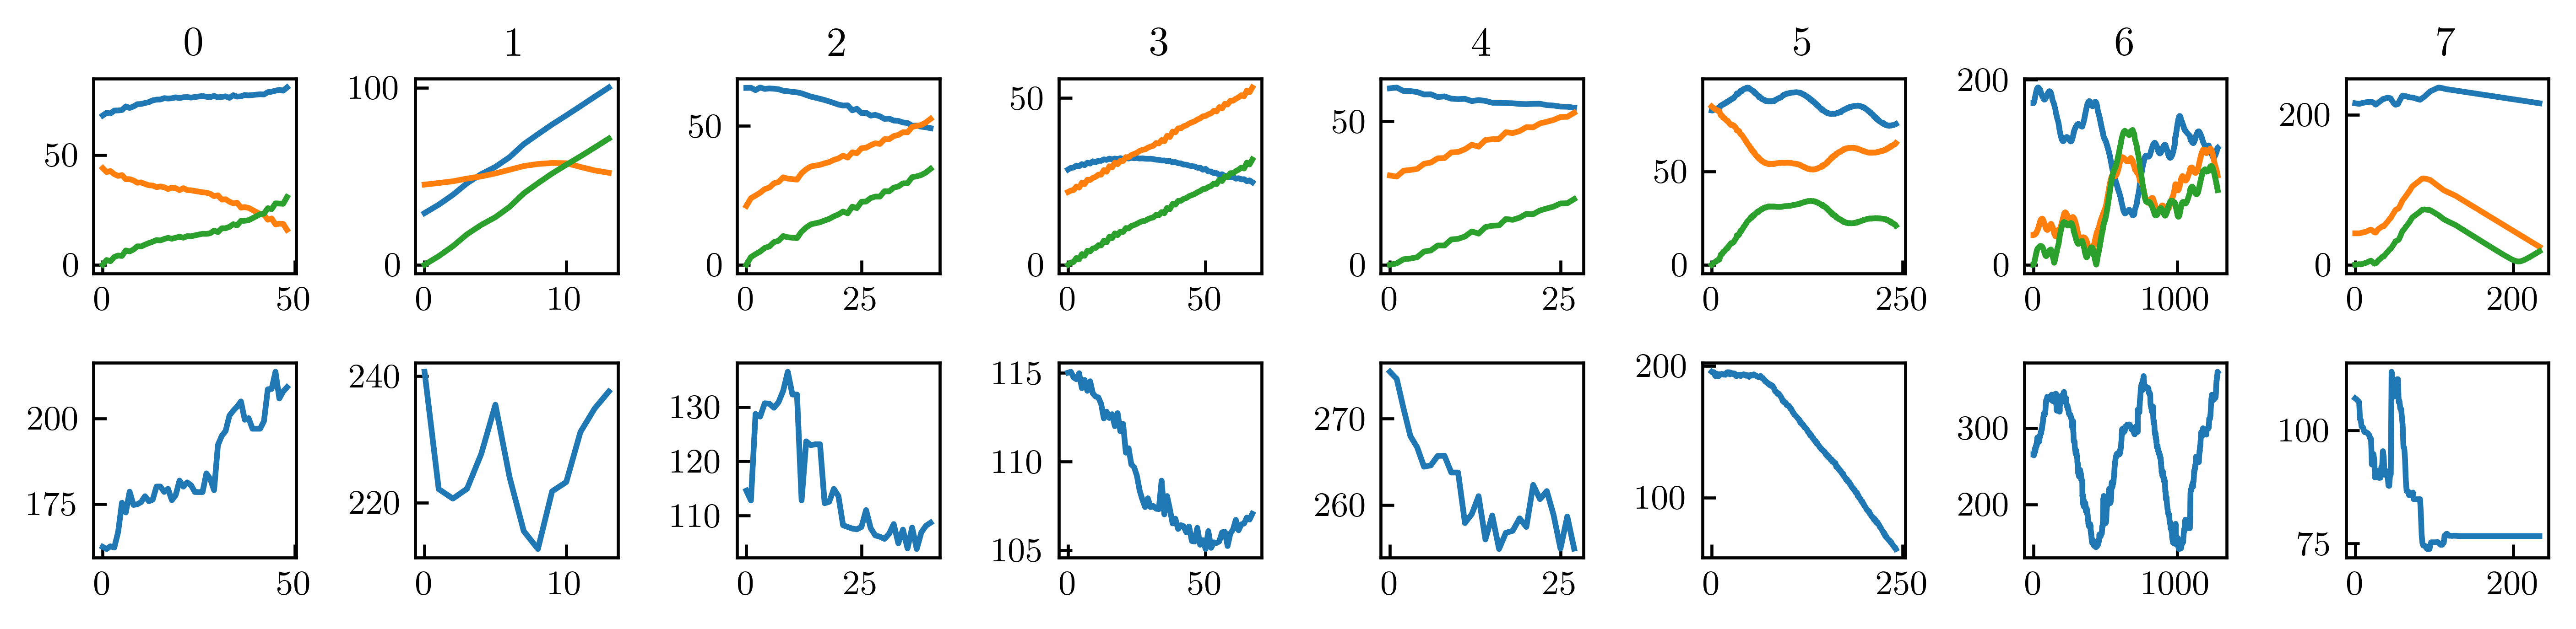

In [13]:
fig, axes = plt.subplots(2, len(dirs), figsize=(3*len(dirs)/2.54, 6/2.54))

for k in range(len(dirs)):
    axes[0,k].plot(pos[:,0,k] * 1e6, ls='-')
    axes[0,k].plot(pos[:,1,k] * 1e6, ls='-')
    axes[0,k].plot(pos[:,3,k] * 1e6, ls='-')
    axes[0,k].set_title(str(k))
    axes[1,k].plot(pos[:,2,k] * 1e6, ls='-')

plt.tight_layout()
plt.show()

In [14]:
for i, d in enumerate(dirs):
    print(i, d)

0 datas_holography/20230517/10_trimmed_2/traj_rp_2p6119_np_1p4965_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_7_s_to_10_s.mat
1 datas_holography/20230517/9_trimmed_2/traj_rp_2p5719_np_1p3906_VideoName_9_Basler_acA1920-155um__22392621__20230517_195639014_trimmed_from_3_s_to_4_s.mat
2 datas_holography/20230517/11_trimmed_1/traj_rp_2p5214_np_1p3877_VideoName_11_Basler_acA1920-155um__22392621__20230517_200203077_trimmed_from_4_s_to_5_s.mat
3 datas_holography/20230517/10_trimmed_1/traj_rp_2p1924_np_1p3934_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_4_s_to_6_s.mat
4 datas_holography/20230517/10_trimmed_3/traj_rp_2p1387_np_1p4057_VideoName_10_Basler_acA1920-155um__22392621__20230517_200002972_trimmed_from_9_s_to_10_s.mat
5 datas_holography/20230511_3rd_slide/4_trimmed_1/traj_rp_3p933_np_1p3933_VideoName_4_Basler_acA1920-155um__22392621__20230511_193611662_trimmed_from_0_s_to_3_s.mat
6 datas_holography/20230511_3rd_slide/2_trimm

In [15]:
to_remove = [7, 4, 2]

In [16]:
for k in to_remove:
    pos[:,:,k] = np.ones(np.shape(pos[:,:,k])) * np.nan

In [17]:
Ntot = len(dirs)
Nexp = len(dirs) - len(to_remove)

# Speed

In [18]:
def speed(x, dt=1e-2):
    res = np.ones_like(x) * np.nan
    res[1:-1] = (x[2:] - x[:-2]) / (2 * dt)
    res[0] = (x[1] - x[0]) / dt
    res[-1] = (x[-1] - x[-2]) / dt
    return res

In [19]:
vv = np.ones((np.shape(pos)[0], np.shape(pos)[2]))

for k in range(Ntot):
    exp = pos[:,:,k]
    fps = fpss[k]
    vx, vy, vz = speed(exp[:,0], dt=1/fps), speed(exp[:,1], dt=1/fps), speed(exp[:,2], dt=1/fps)
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # vv[k] = np.nanmean(v)
    vv[:len(v),k] = np.copy(v)

vv = pd.DataFrame(vv)

vv = vv.drop(to_remove, axis=1)

print(vv)

             0         1         3         5         6
0     0.000223  0.000479  0.000066  0.000062  0.000000
1     0.000081  0.000283  0.000044  0.000048  0.000066
2     0.000073  0.000155  0.000073  0.000039  0.000089
3     0.000245  0.000174  0.000042  0.000096  0.000099
4     0.000657  0.000206  0.000066  0.000153  0.000122
...        ...       ...       ...       ...       ...
1275       NaN       NaN       NaN       NaN  0.000085
1276       NaN       NaN       NaN       NaN  0.000182
1277       NaN       NaN       NaN       NaN  0.000346
1278       NaN       NaN       NaN       NaN  0.000179
1279       NaN       NaN       NaN       NaN  0.000091

[1280 rows x 5 columns]


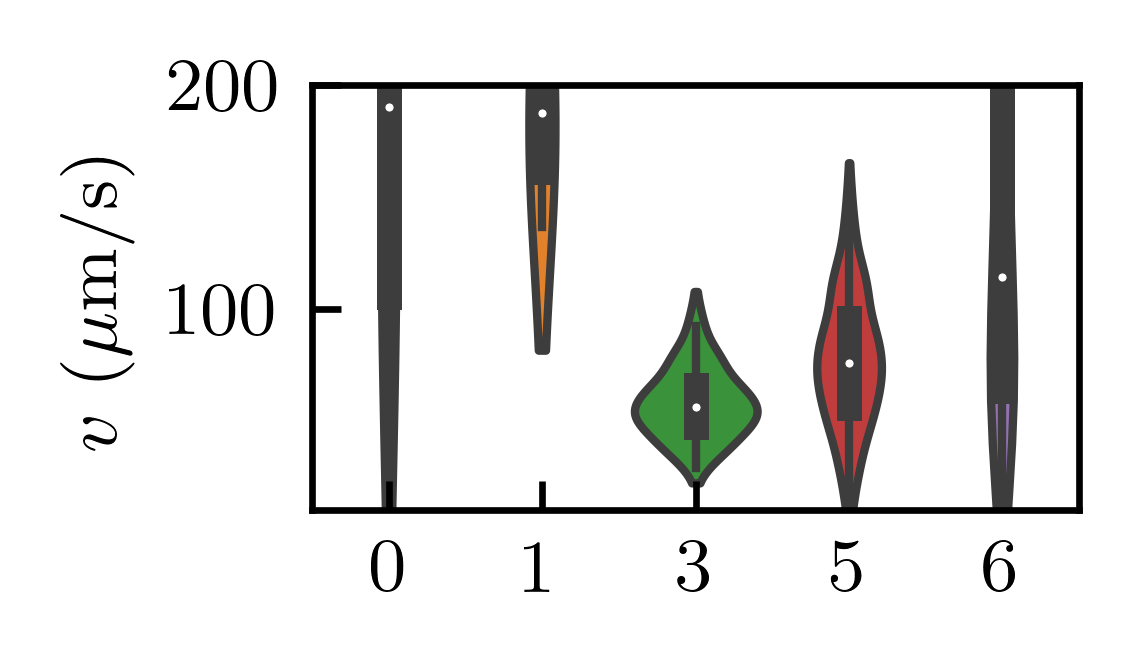

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5/2.54, 3/2.54))

sns.violinplot(data=vv*1e6, bw_adjust=.5, cut=1, linewidth=1, ax=ax)

# ax.set_yscale('log')
ax.set_ylabel(r'$v$ ($\mu$m/s)')
ax.set_ylim([10, 200])

plt.tight_layout()
plt.show()

# Oscilations

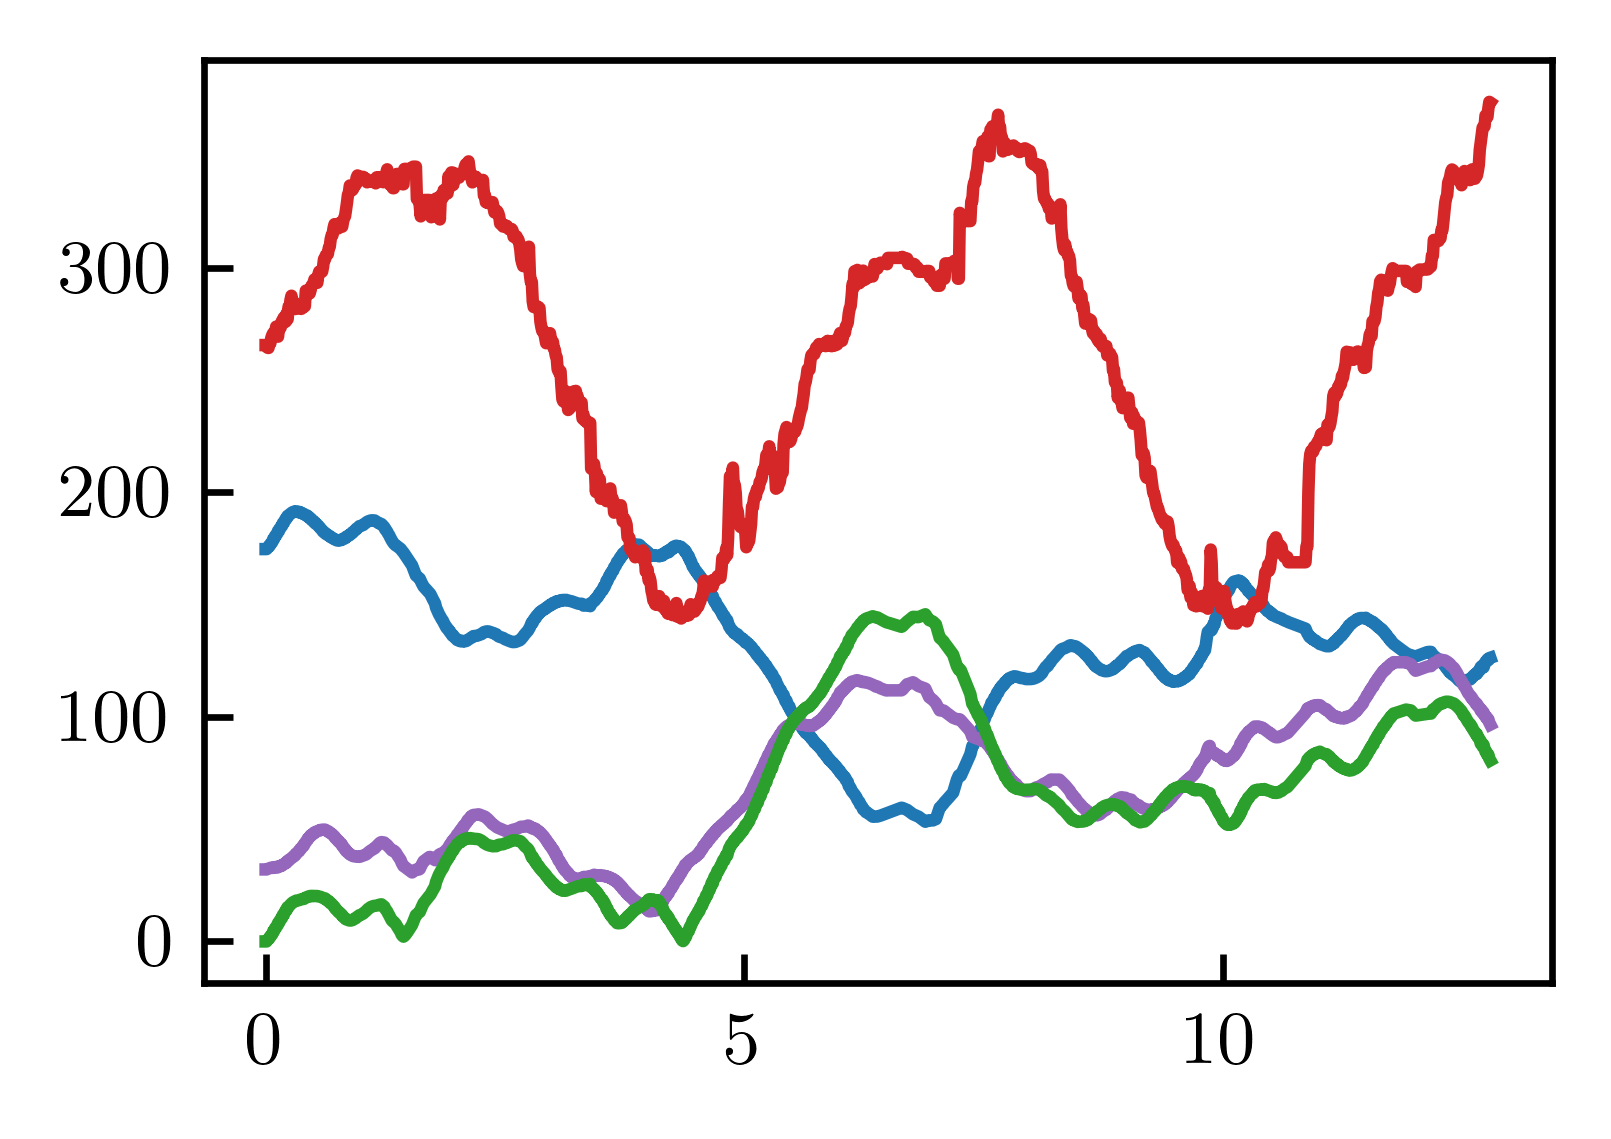

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7/2.54, 5/2.54))

k = 6
x = pos[:,0,k]
y = pos[:,1,k]
z = pos[:,2,k]
r = pos[:,3,k]
t = np.arange(len(x)) / fpss[k]

ax.plot(t, x * 1e6, c='tab:blue')
ax.plot(t, y * 1e6, c='tab:purple')
ax.plot(t, r * 1e6, c='tab:green')
ax.plot(t, z * 1e6, c='tab:red')

plt.tight_layout()
plt.show()

# Spectrum

In [22]:
fx, Pxx = signal.periodogram(x[~np.isnan(x)], fs=fpss[k])
fz, Pzz = signal.periodogram(z[~np.isnan(z)], fs=fpss[k])

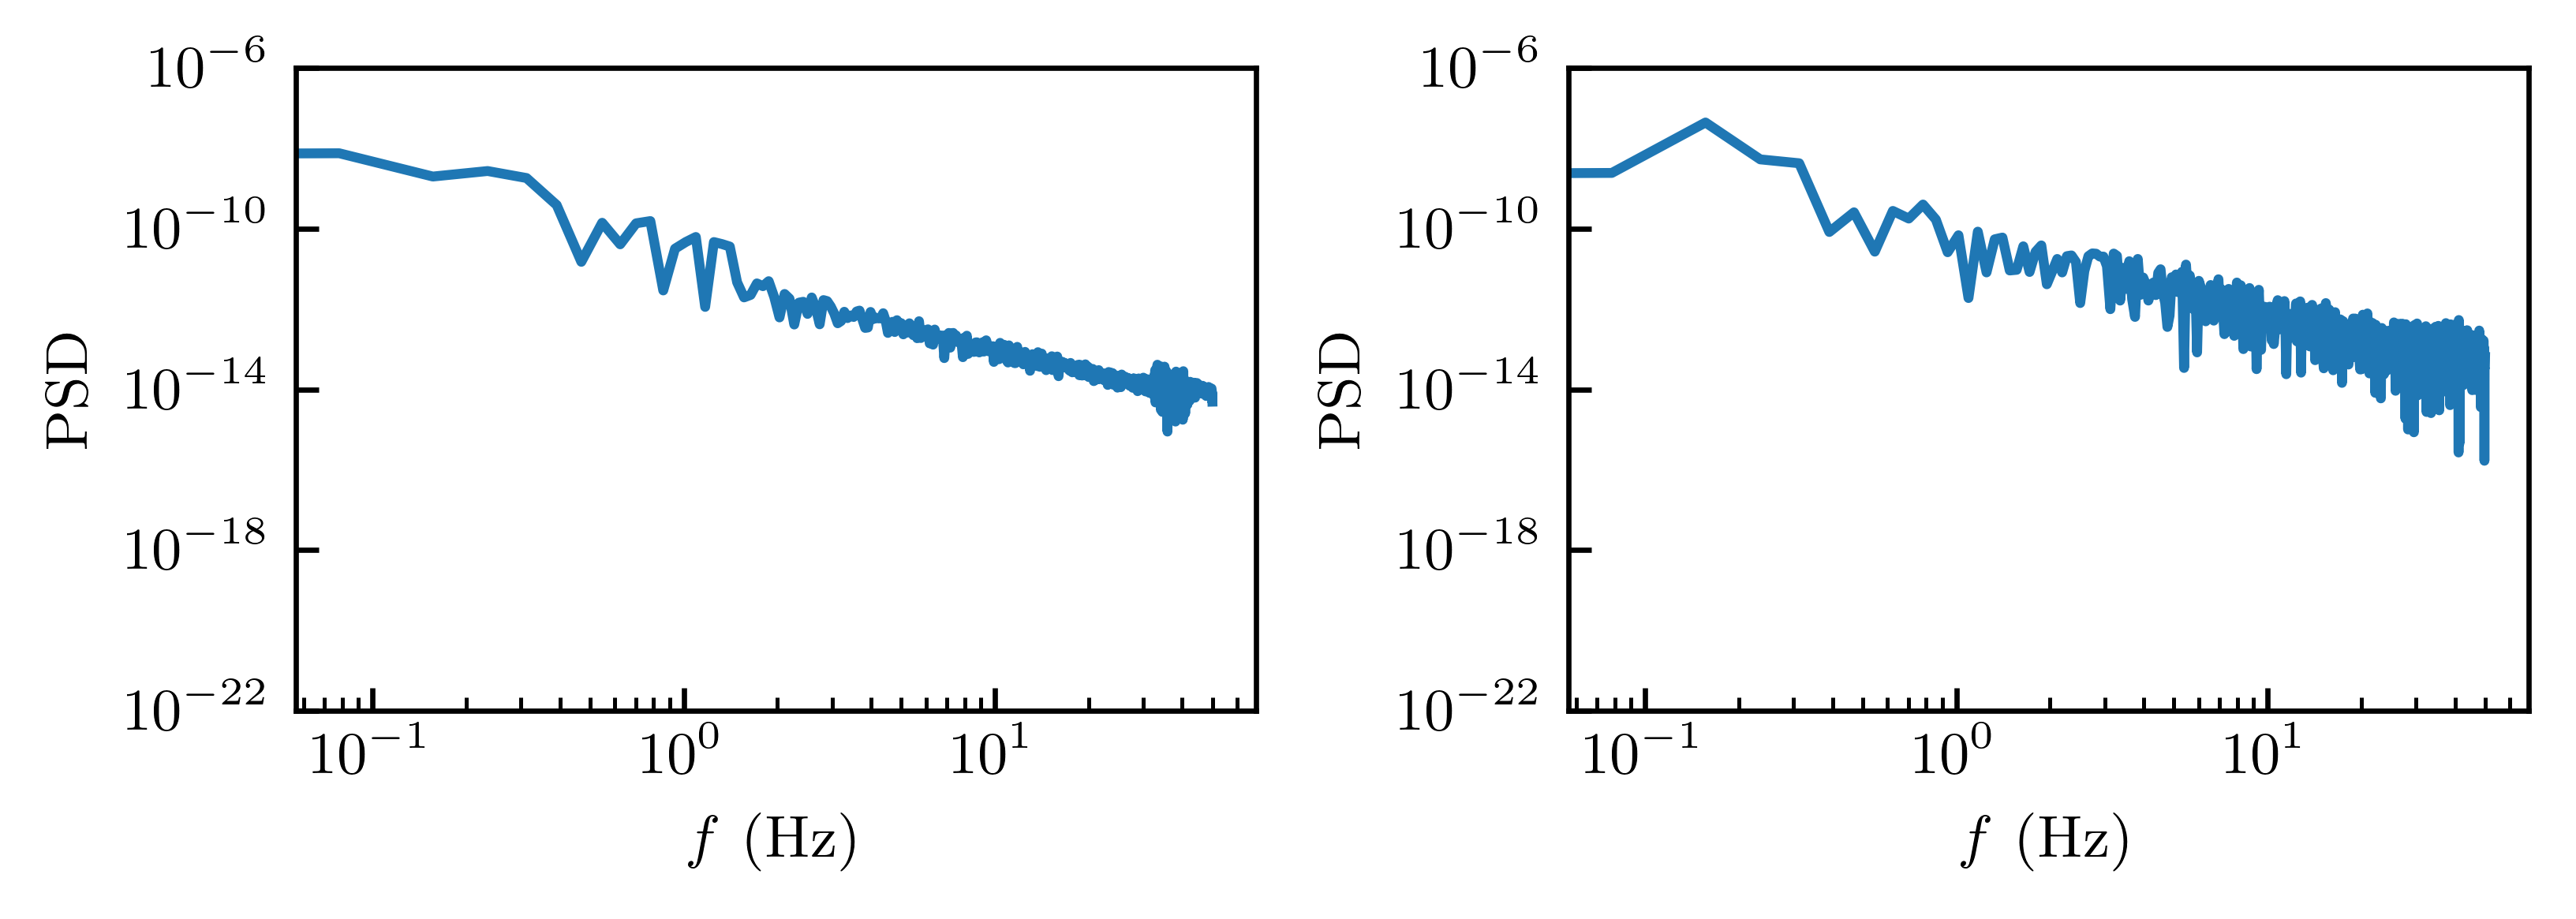

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14/2.54, 5/2.54))

axes[0].plot(fx, Pxx, ls='-', c='tab:blue')

axes[0].set(xlabel=r'$f$ (Hz)', ylabel=r'PSD', xscale='log', yscale='log', ylim=[1e-22,1e-6])

axes[1].plot(fz, Pzz, ls='-', c='tab:blue')

axes[1].set(xlabel=r'$f$ (Hz)', ylabel=r'PSD', xscale='log', yscale='log', ylim=[1e-22,1e-6])

plt.tight_layout()
plt.show()

# Plot Trajectories

In [65]:
ks = [3, 5, 6]

In [72]:
k = ks[2]

In [73]:
posk = pos[:,:,k]
posk = posk[:len(posk[~np.isnan(posk)]),:]
x, y, z = posk[:,0], posk[:,1], posk[:,2]
frames = np.arange(len(x))
# frames

In [74]:
from mycolorpy import colorlist as mcp

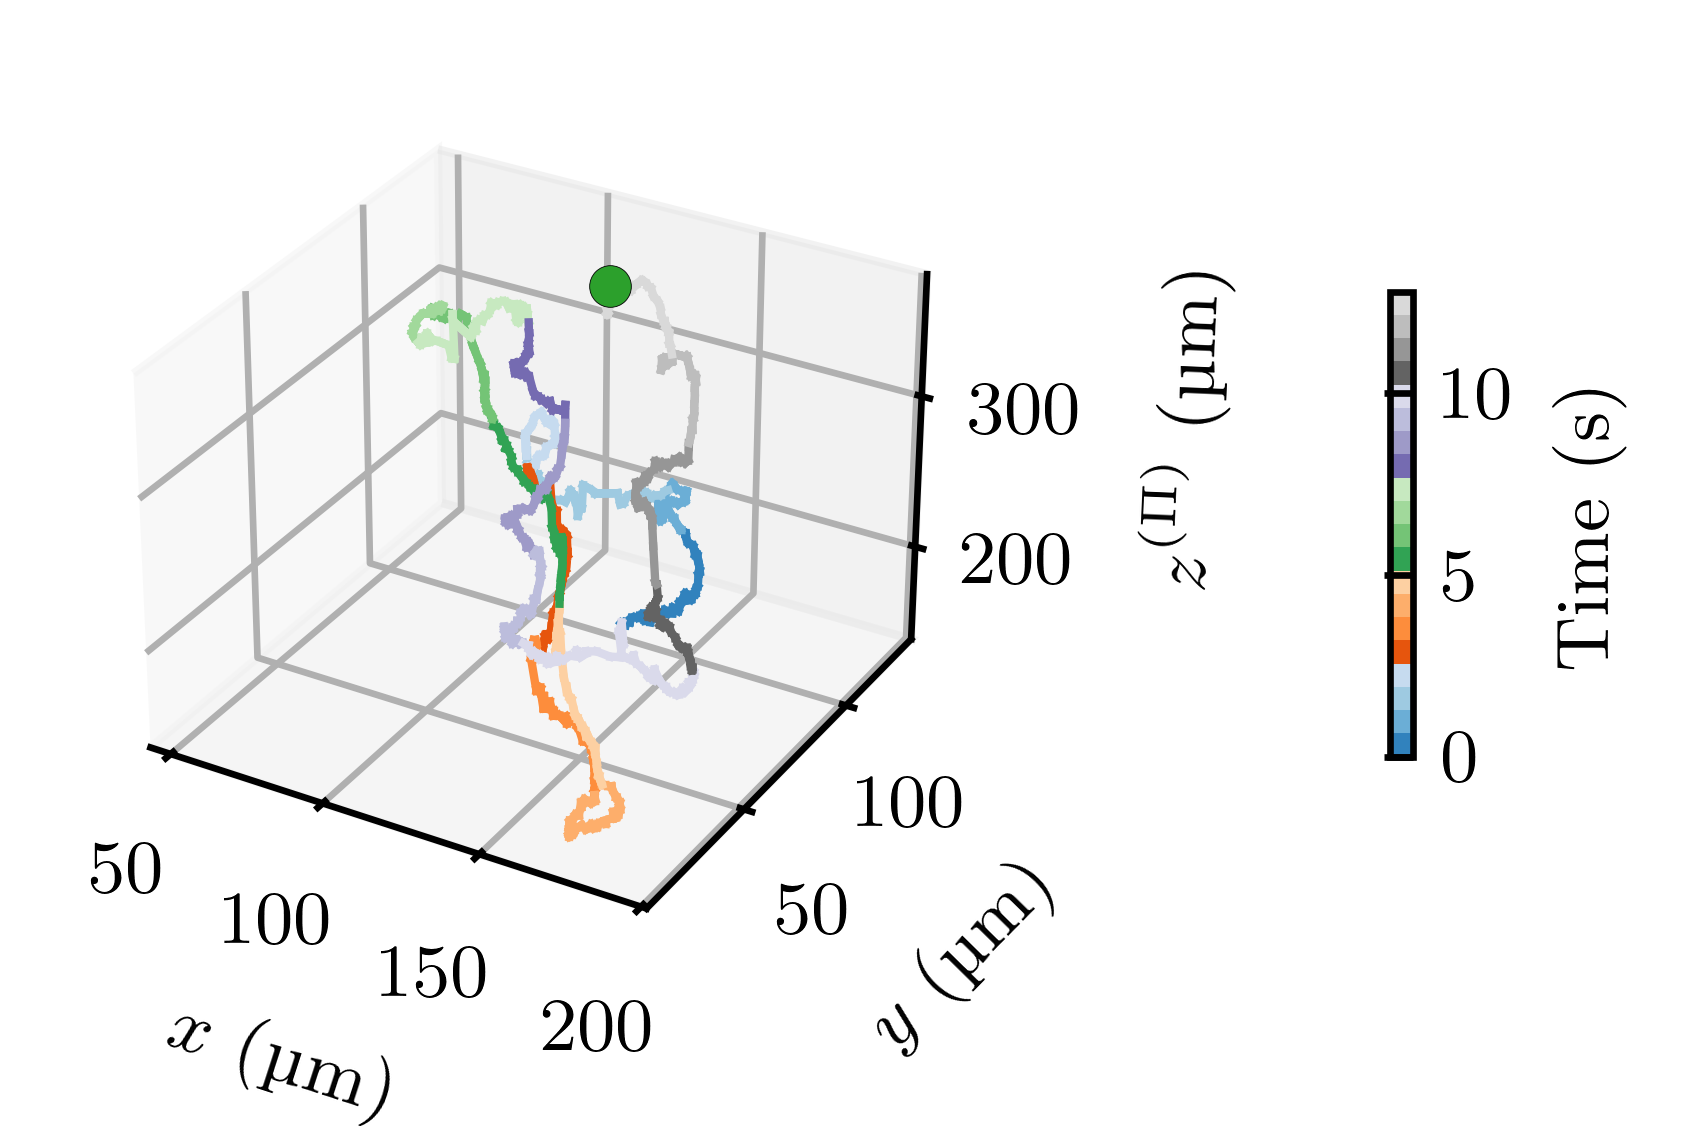

In [92]:
fig = plt.figure(figsize=(7/2.54,4/2.54))
ax = fig.add_subplot(111,projection='3d')


start = 0
stop = len(frames) - 1
step = 1
# ax.scatter3D(
#     x[start:stop:step] * 1e6, y[start:stop:step] * 1e6, z[start:stop:step] * 1e6, 
#     marker='o', s=2, alpha=1,
#     c=time[start:stop:step], cmap=mpl.cm.viridis, 
# )
# ax.plot(x[start:stop:step] * 1e6, y[start:stop:step] * 1e6, z[start:stop:step] * 1e6)
# ax.plot(x[stop-step] * 1e6, y[stop-step] * 1e6, z[stop-step] * 1e6, 'o', c='tab:red', markersize=5)

colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=frames[-1]/fpss[k]), cmap=mpl.cm.tab20c), 
             ax=ax, orientation='vertical', shrink=0.5, pad=0.25, 
             label="Time (s)"
            )

colors = mcp.gen_color(cmap='tab20c', n=int((stop-start)/step))

for i in range(start, stop, step):
    ax.plot(x[i:i+2*step:step] * 1e6, y[i:i+2*step:step] * 1e6, z[i:i+2*step:step] * 1e6, ls='-', linewidth=1, c=colors[i])
ax.plot(x[stop] * 1e6, y[stop] * 1e6, z[stop] * 1e6, 'o', c='tab:green', markersize=5,mew=0.1, zorder=3)
    

ax.set_xlabel(r"$x$ (µm)", labelpad=0.01)
ax.set_ylabel(r"$y$ (µm)", labelpad=0.01)
ax.set_zlabel(r"$z^{(\Pi)}$ (µm)", labelpad=0.01)

ax.tick_params(axis='x', which='both', pad=0.1)
ax.tick_params(axis='y', which='both', pad=0.1)
ax.tick_params(axis='z', which='both', pad=0.1)
# ax.tick_params(axis='x', which='minor', pad=4, length=2, width=1)
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(1)

# ax2.text(-0.5, -14, 0, r"$x$ ($\mathrm{\mu m}$)")
# # ax2.text(4, 5, 7.1, r"$y$ ($\mathrm{\mu m}$)")
# ax2.text(4, 5, 7.1, r"$z$ ($\mathrm{\mu m}$)")

ax.set_box_aspect(None, zoom=0.95)

fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=-1)

# plt.tight_layout(pad=2)
plt.show()

In [94]:
# fig.savefig('traj_3D_chlamys_20230511_2_trimmed_1_test2.pdf', bbox_inches='tight')